1. 导库
2. conv
3. prelu
4. pooling
5. softmax
6. 载入数据
6. 图像金字塔
7. BBox,nms对结果进行过滤
9. proposal
10. crop
11. refine 二次过滤
12. onet
13. 传入图片

In [237]:
import numpy as np
import struct
import random
import matplotlib.pyplot as plt
import pandas as pd
import math
import cv2
import mtcnn.caffe_pb2 as pb
import math

In [253]:
class CaffeModelLoader:
    def load(self, file, *module_pairs):
        net = pb.NetParameter()
        with open(file, "rb") as f:
            net.ParseFromString(f.read())
            
        layer_map = {layer.name : layer for layer in net.layer}
        for layer_name, layer_module in module_pairs:
            if isinstance(layer_module, Conv2d):
                fill_conv(layer_module, layer_map[layer_name])
            elif isinstance(layer_module, PReLU):
                fill_prelu(layer_module, layer_map[layer_name])
            elif isinstance(layer_module, Linear):
                fill_linear(layer_module, layer_map[layer_name])
                
class Module:
    def __init__(self, name):
        self.name = name
        self.train_mode = False
        
    def __call__(self, *args):
        return self.forward(*args)

class Parameter:
    def __init__(self, value):
        self.value = value
        self.delta = np.zeros(value.shape)
        
class Linear(Module):
    def __init__(self, input_feature, output_feature):
        super().__init__("Linear")
        self.input_feature = input_feature
        self.output_feature = output_feature
        self.weights = Parameter(np.zeros((input_feature, output_feature)))
        self.bias = Parameter(np.zeros((1, output_feature)))
        
    def forward(self, x):
        self.x_save = x.copy()
        return x @ self.weights.value + self.bias.value
    
class ModuleList(Module):
    def __init__(self, *args):
        super().__init__("ModuleList")
        self.ms = list(args)
        
    def modules(self):
        return self.ms
    
    def forward(self, x):
        for m in self.ms:
            x = m(x)
        return x

In [251]:
class Conv2d(Module):
    def __init__(self, in_feature, out_feature, k_size, padding=0, stride=1):
        super().__init__("Conv2d") 
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.k_size = k_size
        self.padding = padding
        self.stride = stride
        self.kernel = Parameter(np.ones((out_feature, in_feature, k_size, k_size))) 
        self.bias = Parameter(np.zeros((out_feature)))
        
    def forward(self, x):
        ib, ic, ih, iw = x.shape
        self.oh = (ih + self.padding * 2 - self.k_size) // self.stride + 1
        self.ow = (iw + self.padding * 2 - self.k_size) // self.stride + 1
        col_w = self.oh * self.ow
        col_h = self.k_size * self.k_size * self.in_feature
        self.col = np.zeros((ib, col_h, col_w))
        self.output = np.zeros((ib, self.out_feature, self.oh, self.ow))
        self.kcol = self.kernel.value.reshape(self.out_feature, -1)
        for b in range(ib):
            for c in range(ic):
                for oy in range(self.oh):
                    for ox in range(self.ow):
                        for ky in range(self.k_size):
                            for kx in range(self.k_size):
                                col_y = ky * self.k_size + kx + c * self.k_size * self.k_size
                                col_x = ox + oy * self.ow
                                ix = ox * self.stride + kx - self.padding
                                iy = oy * self.stride + ky - self.padding
                                if ix >= 0 and iy >= 0 and ix < iw and iy < ih:
                                    self.col[b, col_y, col_x] = x[b, c, iy, ix]
            self.output[b] = (self.kcol @ self.col[b]).reshape(self.out_feature, self.oh, self.ow) + self.bias.value.reshape(self.out_feature, 1, 1)
        return self.output
    
class Flatten(Module):
    def __init__(self):
        super().__init__("Flatten")
        
    def forward(self, x):
        self.in_shape = x.shape
        out = x.reshape(self.in_shape[0], -1)
        return out
    
    def backward(self, G):
        return G.reshape(self.in_shape)
    
class PReLU(Module):
    def __init__(self, num_feature, inplace=False):
        super().__init__("PReLU")
        self.inplace = inplace
        self.coeff = Parameter(np.zeros((num_feature)))
        
    def forward(self, x):
        if not self.inplace:
            x = x.copy()
        
        channel = x.shape[1]
        for c in range(channel):
            current_channel = x[:, c]
            select = current_channel < 0
            current_channel[select] *= self.coeff.value[c]
        return x
    
class MaxPooling2d(Module):
    def __init__(self, k_size=2, stride=2):
        super().__init__("MaxPooling2d")
        self.k_size = k_size
        self.stride = stride
        
    def forward(self, x):
        ib, ic, ih, iw = x.shape
        oh, ow = int(np.ceil((ih - self.k_size) / self.stride) + 1), int(np.ceil((iw - self.k_size) / self.stride) + 1)
        output = np.zeros((ib, ic, oh, ow))
        for b in range(ib):
            for c in range(ic):
                for oy in range(oh):
                    for ox in range(ow):
                        ix = ox * self.stride
                        iy = oy * self.stride
                        output[b, c, oy, ox] = x[b, c, iy, ix]
                        
                        for kx in range(self.k_size):
                            for ky in range(self.k_size):
                                ix = ox * self.stride + kx
                                iy = oy * self.stride + ky
                                if ix < iw and iy < ih:
                                    output[b, c, oy, ox] = max(x[b, c, iy, ix], output[b, c, oy, ox])
        return output


In [252]:
class Softmax(Module):
    def __init__(self):
        super().__init__("Softmax")
        
    def forward(self, x):
        expx = np.exp(x)
        sumx = np.sum(expx, axis=1, keepdims=True)
        return expx / sumx

In [240]:
def fill_conv(layer_module, layer_weight):
    kernel_param = layer_module.kernel
    bias_param = layer_module.bias
    kernel_param.value[...] = np.array(layer_weight.blobs[0].data, dtype=np.float32).reshape(kernel_param.value.shape)
    bias_param.value[...] = np.array(layer_weight.blobs[1].data, dtype=np.float32).reshape(bias_param.value.shape)
    
def fill_prelu(layer_module, layer_weight):
    coeff_param = layer_module.coeff
    coeff_param.value[...] = np.array(layer_weight.blobs[0].data, dtype=np.float32).reshape(coeff_param.value.shape)

def fill_linear(layer_module, layer_weight):
    weights_param = layer_module.weights
    bias_param = layer_module.bias
    weights_param.value[...] = np.array(layer_weight.blobs[0].data, dtype=np.float32).reshape(*layer_weight.blobs[0].shape.dim).T
    bias_param.value[...] = np.array(layer_weight.blobs[1].data, dtype=np.float32).reshape(bias_param.value.shape)

In [241]:
class Net(Module):
    def __init__(self, name, size):
        super().__init__(name)
        self.size = size
                
                
class PNet(Net, CaffeModelLoader):
    def __init__(self, file):
        super().__init__("PNet", 12)
        self.backbone = ModuleList(
            Conv2d(3, 10, 3),
            PReLU(10),
            MaxPooling2d(),
            Conv2d(10, 16, 3),
            PReLU(16),
            Conv2d(16, 32, 3),
            PReLU(32),
        )
        
        self.head_confidence = Conv2d(32, 2, 1)
        self.head_bbox = Conv2d(32, 4, 1)
        self.softmax = Softmax()
        
        self.load(file, 
            *list(zip(["conv1", "PReLU1", "pool1", "conv2", "PReLU2", "conv3", "PReLU3"], self.backbone.ms)),
            *list(zip(["conv4-1", "conv4-2"], [self.head_confidence, self.head_bbox]))
        )
        
    def forward(self, x):
        x = self.backbone(x)
        return self.softmax(self.head_confidence(x)), self.head_bbox(x)
    
        
class RNet(Net, CaffeModelLoader):
    def __init__(self, file):
        super().__init__("RNet", 24)
        self.backbone = ModuleList(
            Conv2d(3, 28, 3),
            PReLU(28),
            MaxPooling2d(3, 2),
            Conv2d(28, 48, 3),
            PReLU(48),
            MaxPooling2d(3, 2),
            Conv2d(48, 64, 2),
            PReLU(64),
            Flatten(),
            Linear(576, 128),
            PReLU(128)
        )
        
        self.head_confidence = Linear(128, 2)
        self.head_bbox = Linear(128, 4)
        self.softmax = Softmax()
        
        self.load(file, 
            *list(zip(["conv1", "prelu1", "pool1", "conv2", "prelu2", "pool2", "conv3", "prelu3", "flatten", "conv4", "prelu4"], self.backbone.ms)),
            *list(zip(["conv5-1", "conv5-2"], [self.head_confidence, self.head_bbox]))
        )
        
    def forward(self, x):
        x = self.backbone(x)
        return self.softmax(self.head_confidence(x)), self.head_bbox(x)
    
    
class ONet(Net, CaffeModelLoader):
    def __init__(self, file):
        super().__init__("ONet", 48)
        self.backbone = ModuleList(
            Conv2d(3, 32, 3),
            PReLU(32),
            MaxPooling2d(3, 2),
            Conv2d(32, 64, 3),
            PReLU(64),
            MaxPooling2d(3, 2),
            Conv2d(64, 64, 3),
            PReLU(64),
            MaxPooling2d(2, 2),
            Conv2d(64, 128, 2),
            PReLU(128),
            Flatten(),
            Linear(1152, 256),
            PReLU(256)
        )
        
        self.head_confidence = Linear(256, 2)
        self.head_bbox = Linear(256, 4)
        self.head_landmark = Linear(256, 10)
        self.softmax = Softmax()
        
        self.load(file, 
            *list(zip(["conv1", "prelu1", "pool1", "conv2", "prelu2", "pool2", "conv3", "prelu3", "pool3", "conv4", "prelu4", "flatten", "conv5", "prelu5"], self.backbone.ms)),
            *list(zip(["conv6-1", "conv6-2", "conv6-3"], [self.head_confidence, self.head_bbox, self.head_landmark]))
        )
        
    def forward(self, x):
        x = self.backbone(x)
        return self.softmax(self.head_confidence(x)), self.head_bbox(x), self.head_landmark(x)

In [254]:
class BBox:
    def __init__(self, x, y, r, b, score = 0):
        self.x, self.y, self.r, self.b, self.score = x, y, r, b, score
        self.frame = []                #框集合
        
    def __and__(self, other):
        
        #交集
        xmax = min(self.r, other.r)        #交集右边为两框的右边小值
        xmin = max(self.x, other.x)        #交集左边为两框的左边大值
        ymin = max(self.y, other.y)
        ymax = min(self.b, other.b)
        cross = BBox(xmin, ymin, xmax, ymax)
        if cross.width <= 0 and cross.height <= 0:
            return 0
        
        return cross.area
    
    def __or__(self, other):
        
        #并集
        cross = self & other
        union = self.area + other.area - cross
        return union
    
    def __xor__(self, other):
        
        #IoU
        cross = self & other
        union = self | other
        return cross / (union + 1e-8)      #避免分母为0
    
    def locations(self):
         return self.x, self.y, self.r, self.b
    @property
    def center(self):
        return (self.x + self.r) / 2, (self.y + self.b) / 2
    @property
    def width(self):
        return self.r - self.x + 1
    @property
    def height(self):
        return self.b - self.y +1
    @property
    def area(self):
        return self.width * self.height
    

def nms(objs, iou_threshold):
    
    objs = sorted(objs, key=lambda x:x.score, reverse = True) #将score从大到小排序
    marks = [False] * len(objs)
    needs = []
    
    for i in range(len(objs)):
        if marks[i]:
            continue                                        #自动跳过被标记为False的值
        
        first_box = objs[i]
        needs.append(first_box)
        
        for j in range(i+1,len(objs)):                     #取出相交的框
            if marks[j]:
                continue
                
            second_box = objs[j]
            iou = first_box ^ second_box                  #计算两个框的IoU
            
            if iou > iou_threshold:
                marks[j] = True                           #去重重叠值较高的框
    return needs

In [242]:
class MTCNN(Module):
    def __init__(self):
        self.pnet = PNet("mtcnn/det1.caffemodel")
        self.rnet = RNet("mtcnn/det2.caffemodel")
        self.onet = ONet("mtcnn/det3.caffemodel")
               
    #图像金字塔
    def pyrdown(self, image, min_f = 12, max_f = 0, factor = 0.709):
        ih, iw = image.shape[:2]
        m = 12 / min_f                                              #初始值
        minl = min(iw, ih)                                          #找出最小边
        scales_select = []                                          #比例集合
        scale = 1                                                   #初始比例
        min_scale = 12 / max_f if max_f != 0 else 0                 #最小比例
        minl *= m                                                   #边界
        t = m * scale                                               #第一张图

        while minl >= 12 and t >= min_scale:        

            t *= factor
            scales_select.append(t)
            minl *= factor

        if len(scales_select) == 0:
            return []

        pyrs = []
        for scale in scales_select:
            pyrs.append([cv2.resize(image, (0, 0), fx = scale, fy = scale), scale])
        return pyrs
        

    def proposal(self, net, pairs, conf_threshold = 0.6, nms_threshold = 0.5, stride = 2  ):
    
        cellsize = net.size                                      #每层框的大小
        objs = []
    
        for image, scale in pairs:                              #取出金字塔图像对
            input_image = image.transpose(2, 1, 0)[None]
            conf, reg = net(input_image)                        #取出PNet结果

            sy, sx = np.where(conf[0, 1] > conf_threshold)      #过滤
            for y, x in zip(sy, sx):
                s = conf[0, 1, y, x]

                # 计算原图上的滑窗坐标
                bx = (y * stride + 1) / scale
                by = (x * stride + 1) / scale
                br = (y * stride + cellsize) / scale
                bb = (x * stride + cellsize) / scale

                # 取出回归中的四个坐标值
                regx = reg[0, 0, y, x]
                regy = reg[0, 1, y, x]
                regr = reg[0, 2, y, x]
                regb = reg[0, 3, y, x]

                #转化到原图上
                bw = br - bx + 1
                bh = bb - by + 1
                bx = bx + regx * bw                # 因为做过归一化，所以要乘回bw
                by = by + regy * bh
                br = br + regr * bw
                bb = bb + regb * bh
                objs.append(BBox(bx, by, br, bb, s))
        objs = nms(objs, nms_threshold)
        return objs

    

    def crop_resize_to(self, src, roi, dst):
        x, y, r, b = roi                           #取出初始框的坐标
        dh, dw = dst.shape[:2]                     #目标框的高宽
        sh, sw = src.shape[:2]                     #原始图的高宽，为后面裁切边界条件做准备
        rh, rw = b - y + 1, r - x + 1              #原始框的高宽
        ws, hs = dw / rw, dh / rh                  #求出两边对应的比例
        s = min(ws, hs)                            #当需要拉伸比例小的边都能融进框内时即可
        new_h, new_w = rh * s, rw * s              #拉伸后的高与宽
        new_x = (dw - new_w) / 2                   #因为是以原点为中心进行拉伸的，所以坐标变换时要取一半
        new_y = (dh - new_h) / 2
        new_r = (dw + new_w) / 2
        new_b = (dh + new_h) / 2 
        lx = int(max(0, min(x+0.5, sw - 1)))       #裁切，把他图像与框的交点坐标算出来，同时设定边界条件
        ly = int(max(0, min(y+0.5, sh - 1)))
        lr = int(max(0, min(r+0.5, sw - 1)))
        lb = int(max(0, min(b+0.5, sh - 1)))
        fina_x = int(max(0, min(new_x - (x - lx) * s + 0.5, dw - 1)))     #通过拉伸把图像的左边在新框里表示出来
        fina_y = int(max(0, min(new_y - (y - ly) * s + 0.5, dh - 1)))
        fina_r = int(max(0, min(new_r - (r - lr) * s + 0.5, dw - 1)))
        fina_b = int(max(0, min(new_b - (b - lb) * s + 0.5, dh - 1)))
        cv2.resize(src[ly:lb+1, lx:lr+1], (fina_r-fina_x+1, fina_b-fina_y+1), dst=dst[fina_y:fina_b+1, fina_x:fina_r+1])   #比例拉伸
        
    def refine(self, net, objs, image, has_landmark, conf_threshold=0.7, nms_threshold=0.7):
        
        if len(objs) == 0:
            return []
        
        batch_crop_image = []
        for obj in objs:
            x, y, r, b = obj.locations()
            maxl = max(obj.width, obj.height) 
            cx, cy = obj.center                    #中心坐标
            x = cx - maxl / 2                      #考虑极端例子,使图像扣的更完整,所以需要用大边       
            y = cy - maxl / 2
            r = cx + maxl / 2
            b = cy + maxl / 2 
            crop_resized = np.zeros((net.size, net.size, 3), dtype=np.float32)
            self.crop_resize_to(image, (x, y, r, b), crop_resized)
            batch_crop_image.append(crop_resized.transpose(2, 1, 0)[None])
            
        batch_image = np.vstack(batch_crop_image)
        predict = net(batch_image)
        conf_all, reg_all = predict[:2]
        cell_size = net.size
        if has_landmark:
            landmark = predict[2]
        
        keep_objs = []
        for batch_index, obj in enumerate(objs):
            conf, reg = conf_all[batch_index, 1], reg_all[batch_index]
            if conf > conf_threshold:                        #过滤
                regx, regy, regr, regb = reg
                maxl = max(obj.width, obj.height)
                cx, cy = obj.center                         #计算两点坐标
                x = cx - (maxl / 2 - regx * maxl)
                y = cy - (maxl / 2 - regy * maxl)
                r = cx + (maxl / 2 + regr * maxl)
                b = cy + (maxl / 2 + regb * maxl)
                new_obj = BBox(x, y, r, b, conf)
                
                if has_landmark:
                    keys = landmark[batch_index]
                    new_obj.landmarks = []
                    for x, y in zip(keys[:5], keys[5:]):
                        x = cx + (x - 0.5) * maxl
                        y = cy + (y - 0.5) * maxl
                        new_obj.landmarks.append((x, y))
                keep_objs.append(new_obj)
                
        return nms(keep_objs, nms_threshold)                  
        
    def detect(self, image, min_size=30, max_face=0):
        
        self.input_image = image[..., ::-1] 
        self.input_image = ((self.input_image - 127.5) / 128.0).astype(np.float32)
        self.pyrs = self.pyrdown(self.input_image, min_size, max_face)
        self.objs = self.proposal(self.pnet, self.pyrs, nms_threshold=0.6)
        self.robjs = self.refine(self.rnet, self.objs, self.input_image, False, nms_threshold=0.6)
        self.oobjs = self.refine(self.onet, self.robjs, self.input_image, True, nms_threshold=0.5)
        return self.oobjs

In [243]:
%%time
mtcnn = MTCNN()

Wall time: 79 ms


Wall time: 1.66 s


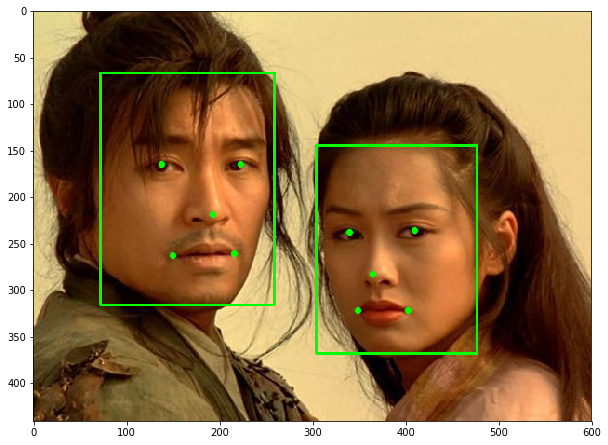

In [244]:
%%time
image = cv2.imread("dhxy.jpg")
objs = mtcnn.detect(image, 150, 300)
for obj in mtcnn.oobjs:
    bx, by, br, bb = np.round(obj.locations()).astype(np.int32)
    cv2.rectangle(image, (bx, by), (br, bb), (0, 255, 0), 2)
    
    for x, y in obj.landmarks:
        cv2.circle(image, (int(x), int(y)), 3, (0, 255, 0), -1, 16)
    
plt.figure(figsize=(10, 10))
plt.imshow(image[...,::-1])

Wall time: 14.1 s


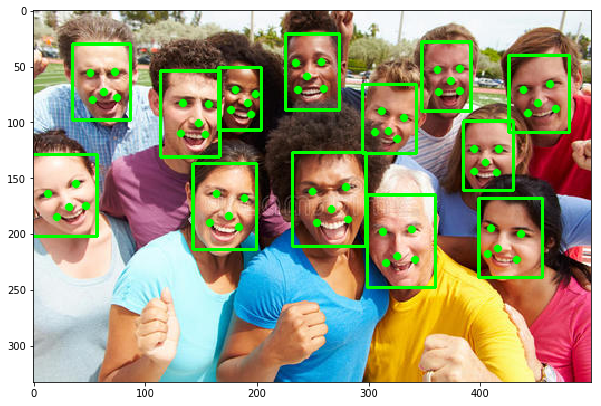

In [245]:
%%time
image = cv2.imread("rq.jpg")
objs = mtcnn.detect(image, 30, 50)
for obj in mtcnn.oobjs:
    bx, by, br, bb = np.round(obj.locations()).astype(np.int32)
    cv2.rectangle(image, (bx, by), (br, bb), (0, 255, 0), 2)
    
    for x, y in obj.landmarks:
        cv2.circle(image, (int(x), int(y)), 3, (0, 255, 0), -1, 16)
    
plt.figure(figsize=(10, 10))
plt.imshow(image[...,::-1])